In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestClassifier

import cluster_pairs as cp

import scipy.stats as stats
import scikit_posthocs as sp 
from statannotations.Annotator import Annotator

import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, get_tx_order


Data prep

In [2]:
#HANN mapping
class_col = 'class_label_Hierarchical'
subclass_col = 'subclass_label_Hierarchical'
cluster_col = 'cluster_label_Hierarchical'

In [3]:
# #Load cell data

out_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20251010_seaad\ME_dprime'
os.makedirs(out_dir, exist_ok=True)

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\ttype_layer_dict.json", "r") as f:
    ttype_to_layer_dict = json.load(f)

with open(r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\L23_ttype_rename.json", "r") as f:
    L23_ttype_rename_dict = json.load(f)

morpho_data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\dendrite'
ephys_spca_data_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20251008\sparse_pca_components_exc_human_May2025_flex.csv'
ephys_raw_data_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20251008\20251008_ephys_features_imputed.csv'

#load the data
metadata = pd.read_csv(os.path.join(morpho_data_root, 'metadata.csv'))
metadata = metadata.rename(columns={"cell_id": "specimen_id", cluster_col: "t_type", subclass_col:'subclass_label'})#, "Pinned Structure and Layer": "final_structure"})
metadata = metadata[['specimen_id', 't_type', 'subclass_label']]
metadata['subclass_label'] = metadata['subclass_label'].replace('_ME', '').replace('(ME)', '')
metadata['t_type'] = metadata['t_type'].replace('L5 ET_ME', 'L5 ET(ME)')
metadata.t_type = metadata.t_type.apply(lambda x: L23_ttype_rename_dict.get(x, x))
metadata['layer'] = metadata["t_type"].map(ttype_to_layer_dict)

#split Layer 2 and 3 subclass
metadata["layer_subclass"] = metadata.apply(
    lambda row: "L2 IT" if row["layer"] == 'Layer 2'
                else ("L3 IT" if row["layer"] == 'Layer 3'
                      else row["subclass_label"]),
    axis=1
)
metadata['specimen_id'] = metadata['specimen_id'].astype('int')
metadata = metadata.set_index('specimen_id')

e_features_spca = pd.read_csv(ephys_spca_data_path, index_col=0)
e_features_imputed = pd.read_csv(ephys_raw_data_path, index_col='specimen_id')
e_features_imputed = e_features_imputed[e_features_imputed.columns[5:]]

m_features_filled = pd.read_csv(os.path.join(morpho_data_root, 'RawFeatureWide_imputed.csv'), index_col='specimen_id')

feature_type = 'ME' #'ME', 'MEspca'

if feature_type == 'ME':
    M_E_features = m_features_filled.merge(e_features_imputed, how='inner', on='specimen_id')
elif feature_type == 'MEspca':
    M_E_features = m_features_filled.merge(e_features_spca, how='inner', left_index=True, right_index=True)
else:
    print(f'Unknown feature_type: {feature_type}')

features = M_E_features.columns.tolist()
data = metadata.merge(M_E_features, how='inner', left_index=True, right_index=True)

In [4]:
#get seaad colors 
color_dict = get_seaad_colors()

#get tx order
ttype_order, subclass_order = get_tx_order()
layer_subclass_order = ['L2 IT'] + [l.replace('L2/3 IT', 'L3 IT') for l in subclass_order]

label_order = {
    'subclass_label' : subclass_order,
    'layer_subclass' :  layer_subclass_order,
    't_type' : ttype_order,
    'layer' : ['Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6']
}

Calculate d' pairwise for all supertypes in a layer. Then take the avg d' value for each layer and compare them. 

In [5]:
layer_dprime_dfs = {}
layer_dprime_records = {}
layer_dprime_avgs = {}
layer_dprime_stds = {}
layer_lost_ttypes = []
for layer in data.layer.unique():
    this_data = data[data['layer'] == layer]
    all_ttypes = set(this_data.t_type.unique())

    #select supertypes with at least 5 cells
    min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
    counts = this_data.t_type.value_counts()
    this_data = this_data[this_data.t_type.map(counts) > min_class_size]

    # Find lost t_types
    remaining_ttypes = set(this_data.t_type.unique())
    lost_ttypes = all_ttypes - remaining_ttypes
    if len(lost_ttypes) > 0:
        layer_lost_ttypes.append(counts[counts.values < 3].to_dict())

    #run pairwise dprime on all supertypes in this layer
    clf = RandomForestClassifier(class_weight='balanced_subsample')
    # clf = GaussianNB()
    m_dprime, m_records = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='t_type', details=True)
    m_dprime = m_dprime.abs()

    #average dprime in this layer 
    dprime_vals = m_dprime.values[np.triu_indices_from(m_dprime, k=1)]
    avg_dprime = dprime_vals.mean()
    std_dprime = dprime_vals.std()
    
    #save
    layer_dprime_dfs[layer] = m_dprime
    layer_dprime_records[layer] = m_records
    layer_dprime_avgs[layer] = avg_dprime
    layer_dprime_stds[layer] = std_dprime


In [6]:
#save lost ttypes df
lost_ttypes_df = pd.DataFrame([{"supertype": k, "count": v} for d in layer_lost_ttypes for k, v in d.items()])
lost_ttypes_df.to_csv(os.path.join(out_dir, f'morphoelectric_{feature_type}_dprime_filtered_ttypes_n_{min_class_size}.csv'), index=False)

In [7]:
# averages and stds in one DF
layer_stats = pd.DataFrame({
    "layer": list(layer_dprime_avgs.keys()),
    "avg_dprime": list(layer_dprime_avgs.values()),
    "std_dprime": list(layer_dprime_stds.values())
}).sort_values(by="layer")

# full distribution of dprime values (for stats)
all_vals = []
for layer, df in layer_dprime_dfs.items():
    rows, cols = np.triu_indices_from(df, k=1)

    for r, c in zip(rows, cols):

        #get each supertype
        c1 = df.index[r]
        c2 = df.columns[c]

        # get subclass for each supertype
        s1 = metadata.loc[metadata.t_type == c1, "subclass_label"].unique()[0]
        s2 = metadata.loc[metadata.t_type == c2, "subclass_label"].unique()[0]

        all_vals.append({
            "layer": layer,
            "dprime": df.iloc[r, c],
            "cluster_1": c1,
            "cluster_2": c2,
            "subclass_1": s1,
            "subclass_2": s2,
            "same_subclass": s1 == s2,
        })

dprime_long = pd.DataFrame(all_vals).sort_values(by=["layer", "dprime"])

In [8]:
#save dprime long for M, E, ME combined plotting later
dprime_long.to_csv(os.path.join(out_dir, 'dprime_layer_ME.csv'), index=False)

Stats

In [9]:
# Global Kruskal-Wallis test
groups = [dprime_long.loc[dprime_long['layer']==layer, "dprime"].values 
          for layer in dprime_long['layer'].unique()]

H, p_kw = stats.kruskal(*groups)
print("Kruskal–Wallis H =", H, "p =", p_kw)


Kruskal–Wallis H = 19.910730387736695 p = 0.000520075853162755


In [10]:
# Dunn’s pairwise test with FDR correction
dunn = sp.posthoc_dunn(dprime_long, val_col="dprime", group_col="layer", p_adjust="fdr_bh")
print(dunn)


          Layer 2   Layer 3   Layer 4   Layer 5   Layer 6
Layer 2  1.000000  0.912688  0.012865  0.012865  0.567341
Layer 3  0.912688  1.000000  0.012865  0.012865  0.553450
Layer 4  0.012865  0.012865  1.000000  0.553450  0.043875
Layer 5  0.012865  0.012865  0.553450  1.000000  0.043875
Layer 6  0.567341  0.553450  0.043875  0.043875  1.000000


Plot

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Layer 3 vs. Layer 4: Custom statistical test, P_val:1.287e-02


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\seaborn\categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)]) for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


Layer 5 vs. Layer 6: Custom statistical test, P_val:4.387e-02
Layer 2 vs. Layer 4: Custom statistical test, P_val:1.287e-02
Layer 3 vs. Layer 5: Custom statistical test, P_val:1.287e-02
Layer 4 vs. Layer 6: Custom statistical test, P_val:4.387e-02
Layer 2 vs. Layer 5: Custom statistical test, P_val:1.287e-02


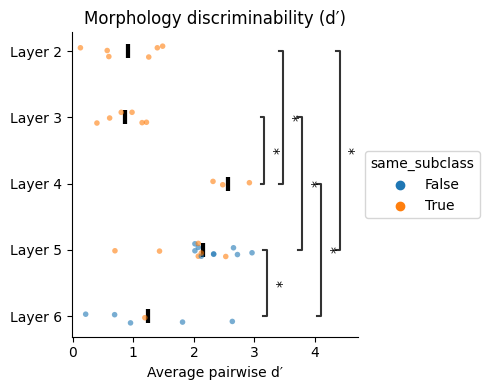

In [11]:
fig, ax = plt.subplots(figsize=(5,4))

#PLOT DATA
sns.stripplot(data=dprime_long, x="dprime", y="layer", hue='same_subclass', size=4, jitter=True, alpha=0.6)
sns.pointplot(data=dprime_long, x='dprime', y='layer', markers="|", scale=1.5, errorbar=None, color='k', join=False, ax=ax)

# #PLOT STATS
all_pairs = [(i, j) for i in layer_stats["layer"] for j in layer_stats["layer"] if i < j]
all_pvals = dunn.values[np.triu_indices_from(dunn, k=1)]

# significant pairs
alpha = 0.05
sig_pairs = [(p, q) for (p, q), pv in zip(all_pairs, all_pvals) if pv < alpha]
sig_pvals = [pv for (p, q), pv in zip(all_pairs, all_pvals) if pv < alpha]

# only annotate if there are significant comparisons
if sig_pairs:
    annotator = Annotator(
        ax, 
        sig_pairs, 
        data=dprime_long, 
        x="dprime",    # now the "x" coordinate is the numeric dprime value
        y="layer",      # y is the categorical layer
        orient="h"
    )
    annotator.configure(test=None, text_format="star", loc="inside")
    annotator.set_pvalues(sig_pvals)
    annotator.annotate()

#FORMAT
sns.despine(top=True, right=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="same_subclass")  # outside right
plt.xlabel("Average pairwise d′")
plt.ylabel("")
plt.title("Morphology discriminability (d′)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f"morphoelectric_{feature_type}_dprime_pairwise_avg_by_layer.pdf"), dpi=600)   # saves current figure as PDF



In [12]:
matrix_colormap = 'rocket' #vidiris #vidiris_r

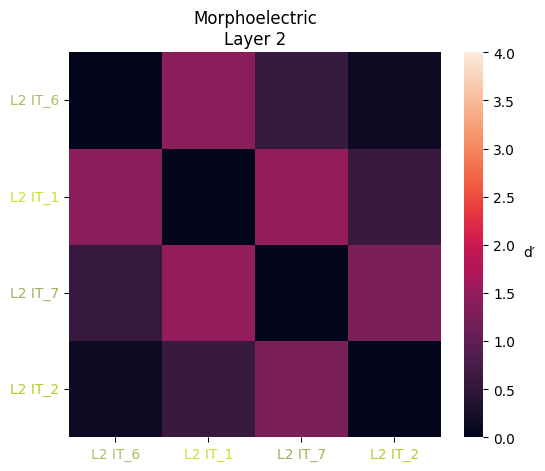

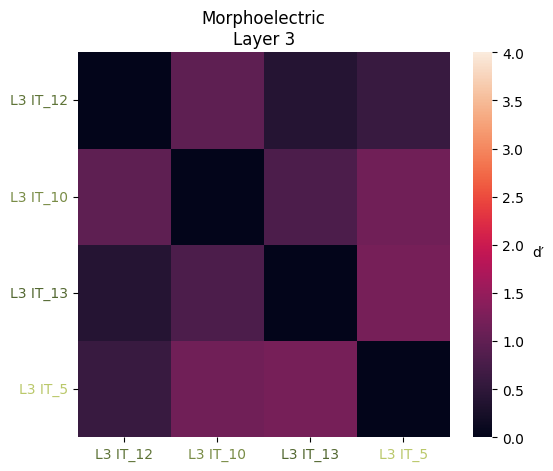

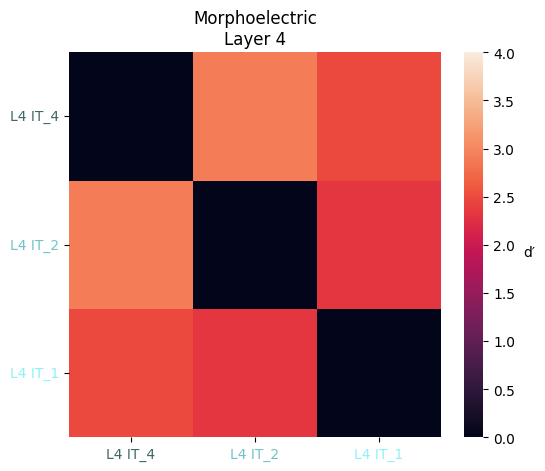

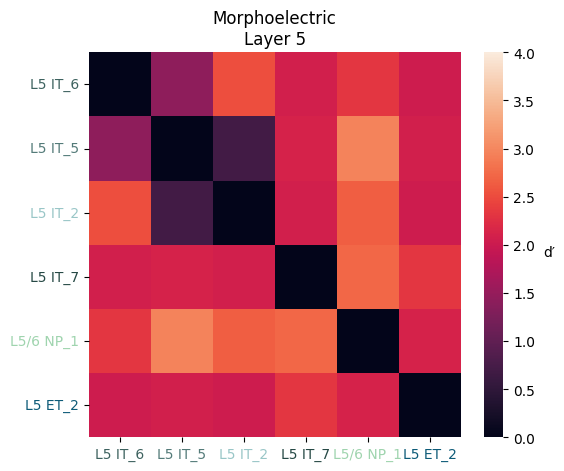

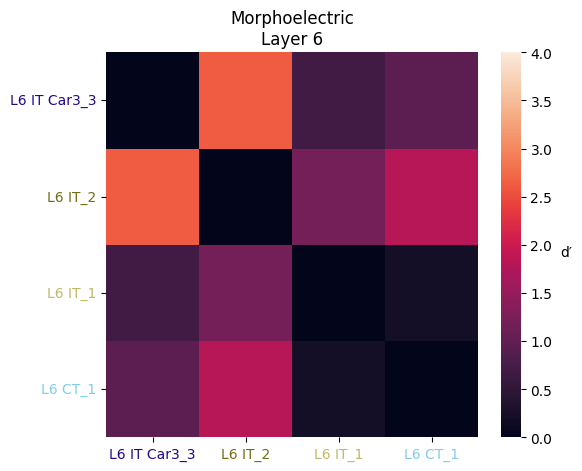

In [13]:
# compute global vmax
all_values = np.concatenate([df.values.flatten() for df in layer_dprime_dfs.values()])
# vmax = all_values.max()
vmax = 4

# open a PDF file
with PdfPages(os.path.join(out_dir, f"morphoelectric_{feature_type}_dprime_cm_supertypes_by_layer.pdf")) as pdf:
    for i in range(2, 7):
        fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
        df = layer_dprime_dfs[f'Layer {i}']
        label_order = [f for f in ttype_order if f in df.columns]

        heat = sns.heatmap(
            df.loc[label_order, label_order],
            annot=False,
            cmap=matrix_colormap,
            cbar=True,
            vmin=0,
            vmax=vmax,
            ax=ax
        )

        plt.yticks(rotation=0)
        plt.title(f'Morphoelectric\nLayer {i}')

        # color tick labels based on color_dict
        for tick in ax.get_xticklabels():
            tick.set_color(color_dict.get(tick.get_text(), "k"))
        for tick in ax.get_yticklabels():
            tick.set_color(color_dict.get(tick.get_text(), "k"))

        # label the colorbar
        cbar = heat.collections[0].colorbar
        cbar.set_label("d′", rotation=0, labelpad=10)

        pdf.savefig(fig, bbox_inches='tight')   # save this figure to the PDF
        plt.show()
        plt.close(fig)     # close to free memory


In [14]:
# compute global vmax
all_values = np.concatenate([df.values.flatten() for df in layer_dprime_dfs.values()])
# vmax = all_values.max()
vmax = 4

with PdfPages(os.path.join(out_dir, f"morphoelectric_{feature_type}_dprime_cm_supertypes_by_layer_triangle.pdf")) as pdf:
    for i in range(2, 7):
        fig, ax = plt.subplots(figsize=(6,5))
        df = layer_dprime_dfs[f'Layer {i}']
        label_order = [f for f in ttype_order if f in df.columns]

        # reorder
        df = df.loc[label_order, label_order]

        # create mask for upper triangle
        mask = np.triu(np.ones_like(df, dtype=bool), k=1)

        # plot only lower triangle
        heat = sns.heatmap(
            df,
            mask=mask,
            annot=False,
            cmap=matrix_colormap,
            cbar=True,
            vmin=0,
            vmax=vmax,
            ax=ax
        )

        plt.yticks(rotation=0)
        plt.title(f'Morphoelectric\nLayer {i}')

        # color tick labels
        for tick in ax.get_xticklabels():
            tick.set_color(color_dict.get(tick.get_text(), "k"))
        for tick in ax.get_yticklabels():
            tick.set_color(color_dict.get(tick.get_text(), "k"))

        # colorbar label
        cbar = heat.collections[0].colorbar
        cbar.set_label("d′", rotation=0, labelpad=10)

        fig.tight_layout()
        pdf.savefig(fig, bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)


In [15]:
all_layers = []

for i in range(2, 7):  # layers 2–6
    df = pd.DataFrame(layer_dprime_records[f'Layer {i}'])
    df["layer"] = f"Layer {i}"
    all_layers.append(df)

feature_importance_df = pd.concat(all_layers, ignore_index=True)
feature_importance_df = feature_importance_df[['layer', 'cluster_1', 'cluster_2', 'importance', 'feature']].sort_values(by=['layer', 'cluster_1', 'cluster_2'])

#save
feature_importance_df.to_csv(os.path.join(out_dir, f'morphoelectric_{feature_type}_dprime_feature_importance.csv'), index=False)

Calculate d' between all subclasses - transcriptomically defined

In [16]:
#select supertypes with at least 5 cells
min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
counts = data.subclass_label.value_counts()
this_data = data[data.subclass_label.map(counts) > min_class_size]

#run pairwise dprime on all subclass in this layer
clf = RandomForestClassifier(class_weight='balanced_subsample')
m_dprime_subclass, m_records_subclass = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='subclass_label', details=True)
m_dprime_subclass = m_dprime_subclass.abs()


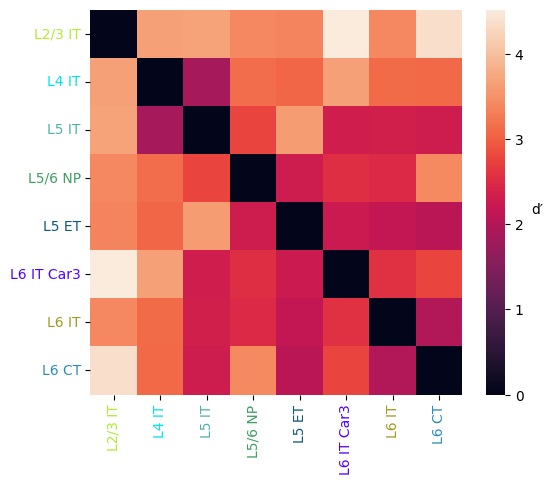

In [17]:
# open a PDF file
with PdfPages(os.path.join(out_dir, f"morphoelectric_{feature_type}_dprime_cm_subclass.pdf")) as pdf:

    fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
    df = m_dprime_subclass
    label_order = [f for f in subclass_order if f in df.columns]

    heat = sns.heatmap(
        df.loc[label_order, label_order],
        annot=False,
        cmap=matrix_colormap,
        cbar=True,
        # vmin=0,
        # vmax=vmax,
        ax=ax
    )

    plt.yticks(rotation=0)
    # plt.title(f'Layer {i}')

    # color tick labels based on color_dict
    for tick in ax.get_xticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))
    for tick in ax.get_yticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))

    # label the colorbar
    cbar = heat.collections[0].colorbar
    cbar.set_label("d′", rotation=0, labelpad=10)

    pdf.savefig(fig)   # save this figure to the PDF
    plt.show()
    plt.close(fig)     # close to free memory


Calculate d' between all subclasses - layer defined

In [18]:
#select supertypes with at least 5 cells
min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
counts = data.subclass_label.value_counts()
this_data = data[data.subclass_label.map(counts) > min_class_size]

#run pairwise dprime on all subclass in this layer
clf = RandomForestClassifier(class_weight='balanced_subsample')
m_dprime_subclass, m_records_subclass = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='layer_subclass', details=True)
m_dprime_subclass = m_dprime_subclass.abs()


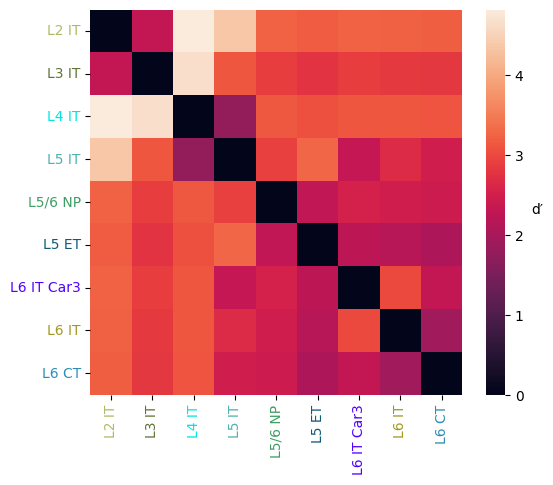

In [19]:
# open a PDF file
with PdfPages(os.path.join(out_dir, f"morphoelectric_{feature_type}_dprime_cm_layerSubclass.pdf")) as pdf:

    fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
    df = m_dprime_subclass
    label_order = [f for f in layer_subclass_order if f in df.columns]

    heat = sns.heatmap(
        df.loc[label_order, label_order],
        annot=False,
        cmap=matrix_colormap,
        cbar=True,
        # vmin=0,
        # vmax=vmax,
        ax=ax
    )

    plt.yticks(rotation=0)
    # plt.title(f'Layer {i}')

    # color tick labels based on color_dict
    for tick in ax.get_xticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))
    for tick in ax.get_yticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))

    # label the colorbar
    cbar = heat.collections[0].colorbar
    cbar.set_label("d′", rotation=0, labelpad=10)

    pdf.savefig(fig)   # save this figure to the PDF
    plt.show()
    plt.close(fig)     # close to free memory


Calculate d' between all layers

In [20]:
#select supertypes with at least 5 cells
min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
counts = data.layer.value_counts()
this_data = data[data.layer.map(counts) > min_class_size]

#run pairwise dprime on all supertypes in this layer
clf = RandomForestClassifier(class_weight='balanced_subsample')
m_dprime_layer, m_records_layer = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='layer', details=True)
m_dprime_layer = m_dprime_layer.abs()


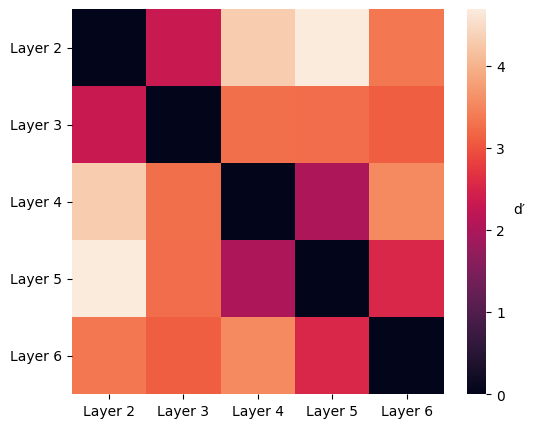

In [21]:
# open a PDF file
with PdfPages(os.path.join(out_dir, f"morphoelectric_{feature_type}_dprime_cm_layer.pdf")) as pdf:

    fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
    df = m_dprime_layer
    label_order = sorted(df.columns.tolist())

    heat = sns.heatmap(
        df.loc[label_order, label_order],
        annot=False,
        cmap=matrix_colormap,
        cbar=True,
        # vmin=0,
        # vmax=vmax,
        ax=ax
    )

    plt.yticks(rotation=0)
    # plt.title(f'Layer {i}')

    # color tick labels based on color_dict
    for tick in ax.get_xticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))
    for tick in ax.get_yticklabels():
        tick.set_color(color_dict.get(tick.get_text(), "k"))

    # label the colorbar
    cbar = heat.collections[0].colorbar
    cbar.set_label("d′", rotation=0, labelpad=10)

    pdf.savefig(fig)   # save this figure to the PDF
    plt.show()
    plt.close(fig)     # close to free memory


Calculate d' pairwise for all supertypes in a subclass. Then take the avg d' value for each subclass and compare them. 

In [22]:
subclass_dprime_dfs = {}
subclass_dprime_records = {}
subclass_dprime_avgs = {}
subclass_dprime_stds = {}
subclass_lost_ttypes = []
for subclass in data.subclass_label.unique():
    this_data = data[data['subclass_label'] == subclass]
    all_ttypes = set(this_data.t_type.unique())

    if len(all_ttypes) > 0 :

        #select supertypes with at least 5 cells
        min_class_size = 3 #because dprime does cv and n_splits=5 cannot be greater than the number of members in each class.
        counts = this_data.t_type.value_counts()
        this_data = this_data[this_data.t_type.map(counts) > min_class_size]

        if len(this_data) > 0:

            # Find lost t_types
            remaining_ttypes = set(this_data.t_type.unique())
            lost_ttypes = all_ttypes - remaining_ttypes
            if len(lost_ttypes) > 0:
                layer_lost_ttypes.append(counts[counts.values < 3].to_dict())

            #run pairwise dprime on all supertypes in this subclass
            clf = RandomForestClassifier(class_weight='balanced_subsample')
            m_dprime, m_records = cp.pairwise_cluster_distances(clf, this_data, features, cv=min_class_size, cluster_label='t_type', details=True)
            m_dprime = m_dprime.abs()

            #average dprime in this subclass 
            dprime_vals = m_dprime.values[np.triu_indices_from(m_dprime, k=1)]
            avg_dprime = dprime_vals.mean()
            std_dprime = dprime_vals.std()
            
            #save
            subclass_dprime_dfs[subclass] = m_dprime
            subclass_dprime_records[subclass] = m_records
            subclass_dprime_avgs[subclass] = avg_dprime
            subclass_dprime_stds[subclass] = std_dprime


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (11). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\sklearn\neighbors\_lof.py:283: UserWarning: n_neighbors (20) is greater than the to

In [23]:
#save lost ttypes df
lost_ttypes_df = pd.DataFrame([{"supertype": k, "count": v} for d in subclass_lost_ttypes for k, v in d.items()])
lost_ttypes_df.to_csv(os.path.join(out_dir, f'morphoelectric_{feature_type}_dprime_filtered_ttypes_n_{min_class_size}_subclass.csv'), index=False)

In [24]:
# averages and stds in one DF
subclass_stats = pd.DataFrame({
    "subclass_label": list(subclass_dprime_avgs.keys()),
    "avg_dprime": list(subclass_dprime_avgs.values()),
    "std_dprime": list(subclass_dprime_stds.values())
}).sort_values(by="subclass_label")

# full distribution of dprime values (for stats)
all_vals = []
for subclass, df in subclass_dprime_dfs.items():
    rows, cols = np.triu_indices_from(df, k=1)

    for r, c in zip(rows, cols):

        #get each supertype
        c1 = df.index[r]
        c2 = df.columns[c]

        all_vals.append({
            "subclass_label": subclass,
            "dprime": df.iloc[r, c],
            "cluster_1": c1,
            "cluster_2": c2,
        })

dprime_long = pd.DataFrame(all_vals).sort_values(by=["subclass_label", "dprime"])

In [25]:
#save dprime long for M, E, ME combined plotting later
dprime_long.to_csv(os.path.join(out_dir, 'dprime_subclass_ME.csv'), index=False)

Stats

In [26]:
# Global Kruskal-Wallis test
groups = [dprime_long.loc[dprime_long['subclass_label']==subclass, "dprime"].values 
          for subclass in dprime_long['subclass_label'].unique()]

H, p_kw = stats.kruskal(*groups)
print("Kruskal–Wallis H =", H, "p =", p_kw)


Kruskal–Wallis H = 4.479508356916149 p = 0.2141253942135062


In [27]:
# Dunn’s pairwise test with FDR correction
dunn = sp.posthoc_dunn(dprime_long, val_col="dprime", group_col="subclass_label", p_adjust="fdr_bh")
print(dunn)


         L2/3 IT     L4 IT     L5 IT     L6 IT
L2/3 IT  1.00000  0.209090  0.993700  0.993700
L4 IT    0.20909  1.000000  0.342128  0.527904
L5 IT    0.99370  0.342128  1.000000  0.993700
L6 IT    0.99370  0.527904  0.993700  1.000000


Plot

c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\seaborn\categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)]) for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


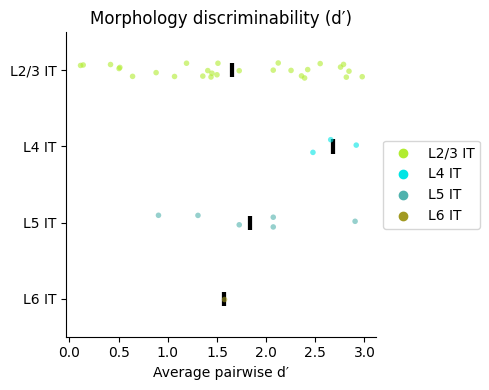

In [28]:
fig, ax = plt.subplots(figsize=(5,4))

#PLOT DATA
sns.stripplot(data=dprime_long, x="dprime", y="subclass_label", hue='subclass_label', palette=color_dict, size=4, jitter=True, alpha=0.6)
sns.pointplot(data=dprime_long, x='dprime', y='subclass_label', markers="|", scale=1.5, errorbar=None, color='k', join=False, ax=ax)

# #PLOT STATS
all_pairs = [(i, j) for i in subclass_stats["subclass_label"] for j in subclass_stats["subclass_label"] if i < j]
all_pvals = dunn.values[np.triu_indices_from(dunn, k=1)]

# significant pairs
alpha = 0.05
sig_pairs = [(p, q) for (p, q), pv in zip(all_pairs, all_pvals) if pv < alpha]
sig_pvals = [pv for (p, q), pv in zip(all_pairs, all_pvals) if pv < alpha]

# only annotate if there are significant comparisons
if sig_pairs:
    annotator = Annotator(
        ax, 
        sig_pairs, 
        data=dprime_long, 
        x="dprime",    # now the "x" coordinate is the numeric dprime value
        y="subclass_label",      # y is the categorical layer
        orient="h"
    )
    annotator.configure(test=None, text_format="star", loc="inside")
    annotator.set_pvalues(sig_pvals)
    annotator.annotate()

#FORMAT
sns.despine(top=True, right=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # outside right
plt.xlabel("Average pairwise d′")
plt.ylabel("")
plt.title("Morphology discriminability (d′)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, f"morphoelectric_{feature_type}_dprime_pairwise_avg_by_subclass.pdf"), dpi=600)   # saves current figure as PDF



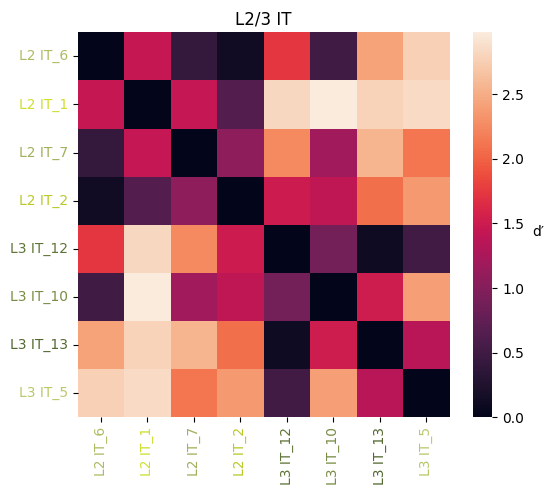

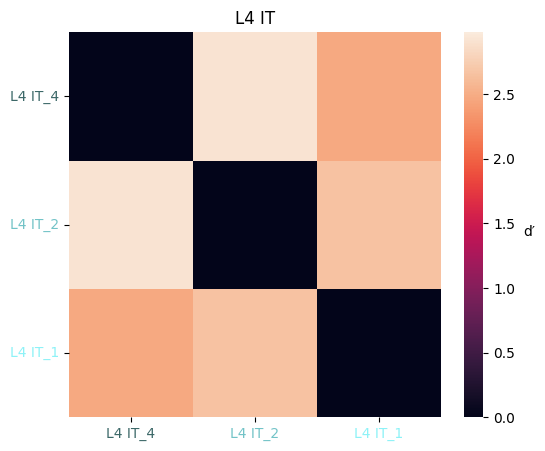

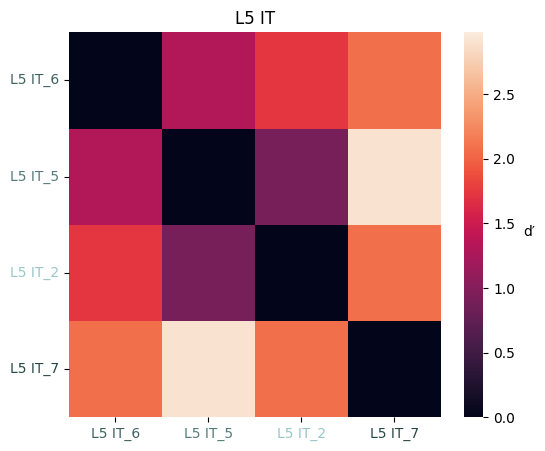

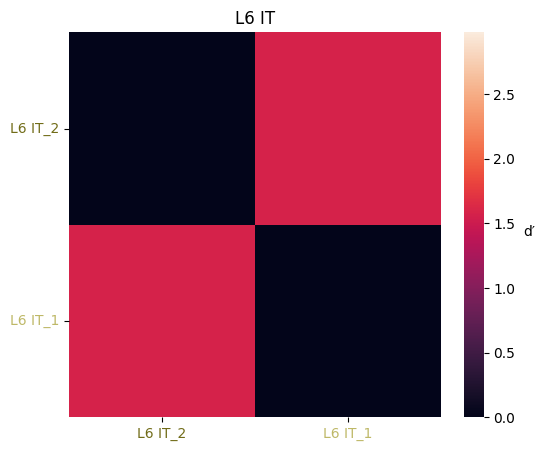

In [29]:
# compute global vmax
all_values = np.concatenate([df.values.flatten() for df in subclass_dprime_dfs.values()])
vmax = all_values.max()

# open a PDF file
with PdfPages(os.path.join(out_dir, f"morphoelectric_{feature_type}_dprime_cm_supertypes_by_subclass.pdf")) as pdf:
    for subclass in sorted(subclass_dprime_dfs.keys()):
        df = subclass_dprime_dfs[subclass]
        if len(df) > 1: 

            fig, ax = plt.subplots(figsize=(6,5))  # optional figsize
            label_order = [f for f in ttype_order if f in df.columns]

            heat = sns.heatmap(
                df.loc[label_order, label_order],
                annot=False,
                cmap=matrix_colormap,
                cbar=True,
                vmin=0,
                vmax=vmax,
                ax=ax
            )

            plt.yticks(rotation=0)
            plt.title(subclass)

            # color tick labels based on color_dict
            for tick in ax.get_xticklabels():
                tick.set_color(color_dict.get(tick.get_text(), "k"))
            for tick in ax.get_yticklabels():
                tick.set_color(color_dict.get(tick.get_text(), "k"))

            # label the colorbar
            cbar = heat.collections[0].colorbar
            cbar.set_label("d′", rotation=0, labelpad=10)

            pdf.savefig(fig)   # save this figure to the PDF
            plt.show()
            plt.close(fig)     # close to free memory
